# **2.Online Retail 장바구니 분석**

# 2.1 2차시 1강

## 2.1.1 Online Retail 데이터 기초분석


### 2.1.1.1 라이브러리 import

In [1]:
# 2.1.1.1 데이터 가공과 기초분석에 필요한 라이브러리 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 2.1.1.2 online retail 파일 적재

In [2]:
# 2.1.1.2 online retail 파일 적재
# 2.1.1.2.1 github 에서 Online Retail.xlsx 파일을 읽어들인다. 

gitpath ='https://github.com/sagelab4data/kdata_yonsei/blob/main/Online%20Retail.xlsx?raw=true'
online = pd.read_excel(gitpath)


In [ ]:
# 2.1.1.2.2 정상적으로 적재되었는지 앞 10행 출력
online.head(10)

### 2.1.1.3 online 개괄 정보 확인 

In [ ]:
# 2.1.1.3 online 개괄 정보 확인 
# 2.1.1.3.1 데이터 프래임  정보 확인 (행, 컬럼 갯수, 컬럼 데이터 타입)
online.***

* Description 과 CustomerID는 결측치가 존재한다. 
* CustomerID는 카레고리형 변수지만 모든 값이 숫자 형태로 존재한다. 
* InvoiceNo, StockCode에는 숫자 값이 아닌 문자열이 존재한다. 

In [ ]:
# 2.1.1.3.2 숫자형 데이터 분포 파악
online.describe().round(2)

In [ ]:
# 2.1.1.3.3  문자, 날짜형 데이터 분포 파악
online.describe(exclude=['float','int'] )

* 25,900 건의 거래 데이터(트랜젝션)가 있다. (unique한 InvoiceNo 수)
* 4070 또는 4223개의 항목(아이템)이 있다. (StockCode, Description의 unique 수)
* Description 에 일부 누락 데이터가 있다. 
* StockCode와 Description의 개수가 정확히 일치하지 않는다.
* Quantity 의 최대값에 80995 , 최소값 -80995 이다. 취소 거래가 예상되며, 큰 값들이 존재하므로 특이치를 고려해야 한다. 
* 총 38개 국가가 있고, United Kingdom이 가장 많은 거래가 있다.  

### 2.1.1.4 고객수, 국가별/월별 거래건수

In [ ]:
# 2.1.1.4 고객수, 국가별/월별 거래건수
# 2.1.1.4.1 고객 수 출력 (숫자형)
print(f'Count of customer ids = {online.CustomerID.nunique()}')

In [ ]:
# 2.1.1.4.2 국가별 거래건수
online.groupby(['Country','InvoiceNo'])['StockCode'].count()\
              .reset_index()['Country'].value_counts()

In [ ]:
# 2.1.1.4.3 월별 거래건수
online.groupby(['InvoiceDate','InvoiceNo'])['StockCode'].count()\
                .reset_index().set_index('InvoiceDate')\
                .resample('M')['InvoiceNo'].count().plot() ;

## 2.1.2 Online Retail 데이터 가공

데이터를 클렌징 (online_tmp) 
* 클렌징 InvoiceNo : 취소 전표 등의 처리 ('C', 'A' ) 등으로 시작하는 InvoiceNo 정리
* 클렌징 Description :  좌우 공백 문자열 제거 및 누락건수 삭제
* 클렌징 Quantity <= 0 인 항목 : 해당 항목 조회 및 조치
* 데이터 모양 변경 : 거래 x  항목 ( InvoiceNo x Description) 형태가 되도록 데이터 형태 변경

### 2.1.2.1 클랜징 InvoiceNo 

In [10]:
# 2.1.2.1 클랜징 InvoiceNo  : 숫자가 아닌 InvoiceNo 처리 
# 2.1.2.1.1 취소거래 등 확인 InvoiceNo의 첫글자가 'C','A' 로 표기된다.  

print ('C로 시작하는 InvoiceNo :' , online.InvoiceNo.str.startswith('C').sum())
print ('A로 시작하는 InvoiceNo :' , online.InvoiceNo.str.startswith('A').sum())
print ('문자가 포함된 InvoiceNo :',(~online.InvoiceNo.astype('str').str.isnumeric()).sum() )

C로 시작하는 InvoiceNo : 9288
A로 시작하는 InvoiceNo : 3
문자가 포함된 InvoiceNo : 9291


In [ ]:
# 2.1.2.1.2 특이한 거래 내용 확인
online[online.InvoiceNo.str.startswith('C')==True].head()

In [ ]:
# 2.1.2.1.3 문자열 포함한 InvoiceNo 행 삭제한 online_tmp 데이터프레임 생성
online_tmp = online[online.InvoiceNo.astype('str').str.isnumeric()].copy()
online_tmp.shape  # 541909 - 9291 = 532618

### 2.1.2.2 클렌징 Description

In [13]:
# 2.1.2.2 클렌징 Description : 좌우 공백 문자열 제거 및 누락건수 삭제
# 2.1.2.2.1 Description에 불필요한 공백 문자가 존재한다. 공백 제거.
print(online_tmp.Description.nunique()) # 기존 항목 종류수
online_tmp['Description'] = online_tmp['Description'].str.strip() # 공백제거
print(online_tmp.Description.nunique()) # 공백 제공후 항목 종류수

4206
4193


In [14]:
# 2.1.2.2.2 Description 공백인 건수 확인
online_tmp.Description.****

1455

In [15]:
# 2.1.2.2.3 Description 공백인 데이터 삭제
online_tmp = online_tmp[~online_tmp.Description.isna()]
online_tmp.shape  # 532618 - 1455 = 531163

(531163, 8)

### 2.1.2.3 클렌징 Quantity <= 0 인 항목

In [ ]:
# 2.1.2.3 클렌징 Quantity <= 0 인 항목 : 해당 항목 조회 및 조치
# 2.1.2.3.1 Quantity <= 0  내용 확인
online_tmp[online_tmp.Quantity<= 0 ]

In [ ]:
# 2.1.2.3.2 Quantity가 음수 인 건 삭제
online_tmp = online_tmp[~(online_tmp.Quantity<= 0) ]
online_tmp.shape # 531163-473 = 530690

### 2.1.2.4 online_tmp 데이터 확인

In [ ]:
# 2.1.2.4 online_tmp 데이터 확인
online_tmp.info()

### 2.1.2.5 데이터 모양 변경

In [19]:
# 2.1.2.5 데이터 모양 변경 : 연관규칙 분석을 수행하기 위한 거래 x 항목 형태로 데이터를 가공한다. 
# 2.1.2.5.1 pivot_table을 이용해서 crosstab을 생성한다. 
online_tmp.pivot_table( ****  )


Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
581584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
581585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### online_tr 생성

In [20]:
# 2.1.2.5.2 crosstab의 내용물이 True, False의 boolean이 되도록 함수를 정의하고 적용한다. 
def isExist(s) :
  if s.count() > 0 :
    return True
  else :
    return False

online_tr = online_tmp.pivot_table(values = 'Quantity',
                       index= 'InvoiceNo', 
                       columns = 'Description',
                        aggfunc =***  ) ***

online_tr

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536366,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536367,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536368,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536369,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581583,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
581584,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
581585,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


* 20,133 행으로 구성된 거래데이터와 4, 064 개의 항목을 갖는 데이터가 준비됨.

### 2.1.2.6 항목별 거래건수 파악

In [21]:
# 2.1.2.6 항목별 거래건수 파악
# 2.1.2.6.1 정리된 online_tr으로 부터 항목별 거래건수를 손쉽게 구할 수 있다. 
online_tr.sum().***

Description
WHITE HANGING HEART T-LIGHT HOLDER    2260
JUMBO BAG RED RETROSPOT               2092
REGENCY CAKESTAND 3 TIER              1989
PARTY BUNTING                         1686
LUNCH BAG RED RETROSPOT               1564
                                      ... 
PEARL & SHELL 42"NECKL. IVORY            1
PAPER CRAFT , LITTLE BIRDIE              1
PAINTED HEART WREATH WITH BELL           1
PACK 4 FLOWER/BUTTERFLY PATCHES          1
wrongly sold (22719) barcode             1
Length: 4064, dtype: int64

In [22]:
# 2.1.2.6.2 더 쉬운 방법
online_tr.sum().***

Description
WHITE HANGING HEART T-LIGHT HOLDER    2260
JUMBO BAG RED RETROSPOT               2092
REGENCY CAKESTAND 3 TIER              1989
PARTY BUNTING                         1686
LUNCH BAG RED RETROSPOT               1564
ASSORTED COLOUR BIRD ORNAMENT         1455
SET OF 3 CAKE TINS PANTRY DESIGN      1385
PACK OF 72 RETROSPOT CAKE CASES       1320
LUNCH BAG  BLACK SKULL.               1273
NATURAL SLATE HEART CHALKBOARD        1249
dtype: int64

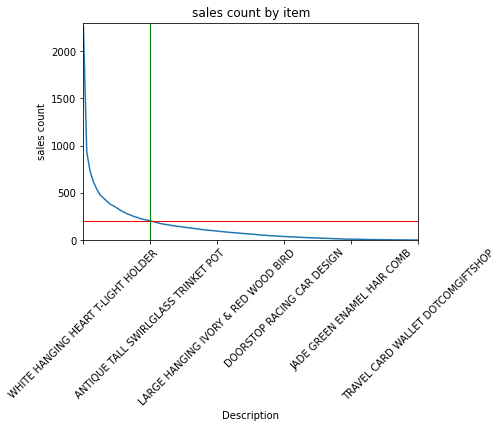

In [135]:
# 2.1.2.6.3  시각화
# 빨간색과 초록색의 수평 수직선은 눈으로 확인하며 적절값을 선정한다. 
# x의 항목개수가 100개가 되도록 데이터 슬라이싱
#  즉, 상품수에서 step 간격을 조정한 슬라이싱 (4064상품/40스텝)

online_tr.sum().sort_values(ascending=False)[::].plot() 
plt.title('sales count by item')
plt.ylabel('sales count')
plt.xticks(rotation=45)
plt.ylim(0,2300)
#plt.xlim(0,100)

#plt.axvline(x=20, color='g', linewidth=1)
#plt.axhline(y=200, color='r', linewidth=1)

plt.show()

* 대략 20%의 항목 (약 800개/4064개)이 1% 이상 (200건 / 20,133건) 구매되고 있음
* 지지도 분석의 시작점을 1%로 해 볼 수 있음 

## 2.1.3 mlxtend를 이용한 간이 분석
* 라이브러리 준비
* 최소지지도 이상의 빈발항목 도출
* 최소신뢰도/최소리프트 이상의 연관규칙 도출
>  mlxtend는 apyori와는 다르게 작동한다. 
> * 입력데이터의 형태가 다르고 (apyori : 컴마로 구분된 트랜젝션별 항목목록 vs. mlxtend : 트랜잭션 x 항목의 crosstab 형태)
> * 진행 방식이 다르다. (apyori : 한 번에 최소지지도, 최소신뢰도 지정 vs. mlxtend : 빈발항목 선정 후 연관규칙 도출) 

### 2.1.3.1 라이브러리 upgrade & import

In [ ]:
# 2.1.3.1 라이브러리 upgrade & import
# 2.1.3.1.1 colab에는 mlxtend 가 설치 되어 있으나 버전이 낮다. 업그레이드 한다. 
!pip install mlxtend -U

In [25]:
# 2.1.3.1.2 mlxtend 라이브러리 import
from mlxtend.frequent_patterns import apriori, association_rules

### 2.1.3.2 빈발항목 생성
* 최소지지도 0.01 이상의 빈발항목 생성

In [26]:
# 2.1.3.2 빈발항목 생성
#  online_tr 데이터를 이용해서 최소지지도 0.01의 빈발 항목집합을 추출
frequent_itemset =*** (***, min_support=***,
                            use_colnames=***,
                            low_memory= ***)
frequent_itemset

,support,itemsets
0,0.015795,(10 COLOUR SPACEBOY PEN)
1,0.012467,(12 MESSAGE CARDS WITH ENVELOPES)
2,0.017633,(12 PENCIL SMALL TUBE WOODLAND)
3,0.017980,(12 PENCILS SMALL TUBE RED RETROSPOT)
4,0.017633,(12 PENCILS SMALL TUBE SKULL)
...,...,...
1848,0.011027,"(JUMBO BAG RED RETROSPOT, JUMBO BAG WOODLAND A..."
1849,0.011176,"(LUNCH BAG BLACK SKULL., LUNCH BAG CARS BLUE,..."
1850,0.010282,"(LUNCH BAG BLACK SKULL., LUNCH BAG CARS BLUE,..."
1851,0.010182,"(LUNCH BAG BLACK SKULL., LUNCH BAG SUKI DESIG..."


### 2.1.3.3 연관규칙 도출
최소지지도 0.01 빈발 항목목록에서 
* 최소신뢰도 0.5 이상의 연관규칙 도출
* 최소리프트 10 이상의 연관규칙 도출

In [27]:
# 2.1.3.3 연관규칙 도출
# 2.1.3.3.1    0.01 지지도 이상의 빈발 항목으로 부터, 0.5 이상의 신뢰도를 갖는 연관 규칙을 도출한다. 
asso_rules = ***   (***, 
                               metric= ***, 
                               min_threshold= ***)
asso_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 72 RETROSPOT CAKE CASES),0.021706,0.065564,0.012020,0.553776,8.446339,0.010597,2.094095
1,(60 TEATIME FAIRY CAKE CASES),(PACK OF 72 RETROSPOT CAKE CASES),0.041127,0.065564,0.022500,0.547101,8.344541,0.019804,2.063235
2,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE GREEN),0.021259,0.048676,0.013759,0.647196,13.295921,0.012724,2.696467
3,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE PINK),0.021259,0.038891,0.010927,0.514019,13.216779,0.010101,1.977666
4,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE RED),0.021259,0.052203,0.014504,0.682243,13.069075,0.013394,2.982773
...,...,...,...,...,...,...,...,...,...
836,"(RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOT...","(STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI ...",0.016143,0.020613,0.010133,0.627692,30.451396,0.009800,2.630585
837,"(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG PI...","(WOODLAND CHARLOTTE BAG, STRAWBERRY CHARLOTTE ...",0.016341,0.020166,0.010133,0.620061,30.747990,0.009803,2.578923
838,"(WOODLAND CHARLOTTE BAG, STRAWBERRY CHARLOTTE ...","(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG PI...",0.020166,0.016341,0.010133,0.502463,30.747990,0.009803,1.977057
839,"(STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG PINK ...","(RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOT...",0.018825,0.016689,0.010133,0.538259,32.252262,0.009818,2.129571


In [28]:
# 2.1.3.3.2 0.01 지지도 이상의 빈발 항목으로 부터, 10 이상의 향상도를 갖는 연관 규칙을 도출한다. 
asso_rules2 = association_rules(***, 
                               metric= ***, 
                               min_threshold= ***)
asso_rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(SCANDINAVIAN REDS RIBBONS),(6 RIBBONS RUSTIC CHARM),0.022401,0.047435,0.010778,0.481153,10.143511,0.009716,1.835927
1,(6 RIBBONS RUSTIC CHARM),(SCANDINAVIAN REDS RIBBONS),0.047435,0.022401,0.010778,0.227225,10.143511,0.009716,1.265050
2,(PACK OF 60 PINK PAISLEY CAKE CASES),(60 CAKE CASES DOLLY GIRL DESIGN),0.043163,0.021706,0.010331,0.239356,11.027336,0.009394,1.286139
3,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 60 PINK PAISLEY CAKE CASES),0.021706,0.043163,0.010331,0.475973,11.027336,0.009394,1.825929
4,(SET OF 20 VINTAGE CHRISTMAS NAPKINS),(60 CAKE CASES VINTAGE CHRISTMAS),0.030299,0.030696,0.013411,0.442623,14.419624,0.012481,1.739046
...,...,...,...,...,...,...,...,...,...
1243,(STRAWBERRY CHARLOTTE BAG),"(RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOT...",0.035862,0.012467,0.010133,0.282548,22.663540,0.009686,1.376445
1244,(WOODLAND CHARLOTTE BAG),"(RED RETROSPOT CHARLOTTE BAG, STRAWBERRY CHARL...",0.041474,0.012169,0.010133,0.244311,20.076412,0.009628,1.307193
1245,(CHARLOTTE BAG SUKI DESIGN),"(RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOT...",0.043809,0.012020,0.010133,0.231293,19.242199,0.009606,1.285248
1246,(CHARLOTTE BAG PINK POLKADOT),"(WOODLAND CHARLOTTE BAG, STRAWBERRY CHARLOTTE ...",0.036905,0.012914,0.010133,0.274563,21.260648,0.009656,1.360677


# 2.2 2차시 2강

### 사전준비
앞서 2차 1강의 수업에서 연속해서 진행하지 않을 경우,  라이브러리 및 분석 결과를 다시 적
* 라이브러리 업그래이드 및 import 
* 파일 읽기
* 클랜징
* 데이터 모양 변경

In [116]:
# 2.2.0.1 colab에는 mlxtend 가 설치 되어 있으나 버전이 낮다. 업그레이드 한다. 
!pip install mlxtend -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
# 2.2.0.2 데이터 가공과 기초분석에 필요한 라이브러리 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# mlxtend 라이브러리 import
from mlxtend.frequent_patterns import apriori, association_rules

In [118]:
# 2.2.0.3 github 에서 Online Retail.xlsx 파일을 읽어들인다. 

gitpath ='https://github.com/sagelab4data/kdata_yonsei/blob/main/Online%20Retail.xlsx?raw=true'
online = pd.read_excel(gitpath)

In [119]:
# 2.1.0.4 클랜징 
online_tmp = online.copy()  # 슬라이스를 사용하지 않기 위해 복제본 생성
online_tmp['Description'] = online_tmp['Description'].str.strip() # Description 앞뒤 공백제거

# 클렌징 규칙 
cleansing_bool = (online.InvoiceNo.astype('str').str.isnumeric()) & \
                  (online_tmp.Description.notnull()) &\
                  (online_tmp.Quantity > 0 )
                  
# online_tmp 필터링
online_tmp = online_tmp[cleansing_bool]

In [120]:
# 2.1.0.5 데이터 확인
online_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530690 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530690 non-null  object        
 1   StockCode    530690 non-null  object        
 2   Description  530690 non-null  object        
 3   Quantity     530690 non-null  int64         
 4   InvoiceDate  530690 non-null  datetime64[ns]
 5   UnitPrice    530690 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      530690 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.4+ MB


In [121]:
# 2.1.0.6 crosstab 형태로 데이터 모양 변경
# apriori 입렵 데이터 생성 시 pivot 집계에 사용할 함수 생성하고 online_tr를 생성
#  (항목 count True/Fasle로 표기)
def isExist(s) :
  return True if s.count() > 0 else False

online_tr =  online_tmp.pivot_table(values = 'Quantity',
                                         index= 'InvoiceNo', 
                                         columns = 'Description',
                                         aggfunc = isExist  ).fillna(False)
online_tr.shape

(20133, 4064)

## 2.2.1 빈발항목 분석

### 2.2.1.1 ms=0.01 빈발항목

##### frequent_itemset

In [35]:
# 2.2.1.1 ms=0.01 빈발항목
#  online_tr 데이터를 이용해서 최소지지도 0.01의 빈발 항목집합을 추출
frequent_itemset = ***

frequent_itemset

,support,itemsets
0,0.015795,(10 COLOUR SPACEBOY PEN)
1,0.012467,(12 MESSAGE CARDS WITH ENVELOPES)
2,0.017633,(12 PENCIL SMALL TUBE WOODLAND)
3,0.017980,(12 PENCILS SMALL TUBE RED RETROSPOT)
4,0.017633,(12 PENCILS SMALL TUBE SKULL)
...,...,...
1848,0.011027,"(JUMBO BAG RED RETROSPOT, JUMBO BAG WOODLAND A..."
1849,0.011176,"(LUNCH BAG BLACK SKULL., LUNCH BAG CARS BLUE,..."
1850,0.010282,"(LUNCH BAG BLACK SKULL., LUNCH BAG CARS BLUE,..."
1851,0.010182,"(LUNCH BAG BLACK SKULL., LUNCH BAG SUKI DESIG..."


* 최소지지도 0.01에서 1853개의 빈발항목을 도출 (단일항목 800여개 포함)

### 2.2.1.2 빈발항목 개괄

In [36]:
# 2.2.1.2 빈발항목 개괄
# 2.2.1.2.1  frequent_itemset의 컬럼 정보 확인
frequent_itemset.***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   support   1853 non-null   float64
 1   itemsets  1853 non-null   object 
dtypes: float64(1), object(1)
memory usage: 29.1+ KB


In [37]:
# 2.2.1.2.2 frequent_itemset.support의 분포
frequent_itemset.***

,support
count,1853.000000
mean,0.016690
std,0.009544
min,0.010033
25%,0.011225
50%,0.013411
75%,0.018179
max,0.112254


### 2.2.1.3 2건 이상 빈발항목

##### freq_its_2

In [38]:
# 2.2.1.3 2건 이상 빈발항목 : freq_its= 2 생성
# 2.2.1.3.1 itemsets의 항목개수를 갖는 length 컬럼 추가

frequent_itemset['length'] = ( 
    frequent_itemset['itemsets'].apply(lambda x : len(x))
)

frequent_itemset.head()

,support,itemsets,length
0,0.015795,(10 COLOUR SPACEBOY PEN),1
1,0.012467,(12 MESSAGE CARDS WITH ENVELOPES),1
2,0.017633,(12 PENCIL SMALL TUBE WOODLAND),1
3,0.017980,(12 PENCILS SMALL TUBE RED RETROSPOT),1
4,0.017633,(12 PENCILS SMALL TUBE SKULL),1


In [39]:
# 2.2.1.3.2 단일항목이 아닌 2건 이상의 항목을 갖는 항목집합을 추출
freq_its_2 = frequent_itemset[frequent_itemset.*** >= 2 ]
freq_its_2

,support,itemsets,length
803,0.010033,"(6 RIBBONS RUSTIC CHARM, DOTCOM POSTAGE)",2
804,0.011722,"(JAM MAKING SET PRINTED, 6 RIBBONS RUSTIC CHARM)",2
805,0.010282,"(JAM MAKING SET WITH JARS, 6 RIBBONS RUSTIC CH...",2
806,0.010778,"(JUMBO BAG RED RETROSPOT, 6 RIBBONS RUSTIC CHARM)",2
807,0.011821,"(PACK OF 72 RETROSPOT CAKE CASES, 6 RIBBONS RU...",2
...,...,...,...
1848,0.011027,"(JUMBO BAG RED RETROSPOT, JUMBO BAG WOODLAND A...",4
1849,0.011176,"(LUNCH BAG BLACK SKULL., LUNCH BAG CARS BLUE,...",4
1850,0.010282,"(LUNCH BAG BLACK SKULL., LUNCH BAG CARS BLUE,...",4
1851,0.010182,"(LUNCH BAG BLACK SKULL., LUNCH BAG SUKI DESIG...",4


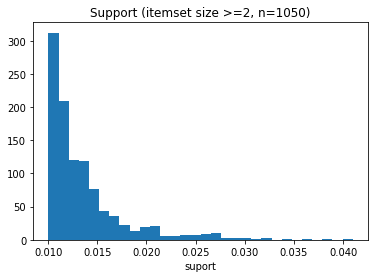

In [40]:
# 2.2.1.3.3 2건 이상 항목집합의 지지도 분포 (히스토그램)
freq_its_2.hist('***', grid=False, bins=30)
plt.title('Support (itemset size >=2, n=1050)')
plt.xlabel('suport')
plt.show()

In [41]:
# 2.2.1.3.4 2건 이상 항목 중 지지도가 0.03 이상인 항목집합 출력 
freq_its_2[***]


,support,itemsets,length
836,0.031789,"(ALARM CLOCK BAKELIKE RED, ALARM CLOCK BAKELIK...",2
1015,0.031441,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",2
1021,0.038146,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",2
1175,0.040977,"(JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS...",2
1216,0.033775,"(JUMBO BAG RED RETROSPOT, JUMBO SHOPPER VINTAG...",2
1218,0.035961,"(JUMBO BAG RED RETROSPOT, JUMBO STORAGE BAG SUKI)",2
1331,0.031838,"(LUNCH BAG BLACK SKULL., LUNCH BAG RED RETROS...",2
1387,0.030100,"(LUNCH BAG RED RETROSPOT, LUNCH BAG PINK POLKA...",2


In [42]:
# 2.2.1.3.5 2건 이상 항목 중 지지도가 0.018~0.022 사이 항목집합 출력 
freq_its_2[freq_its_2.support.***]


,support,itemsets,length
835,0.020762,"(ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKEL...",2
841,0.018527,"(ALARM CLOCK BAKELIKE RED, ALARM CLOCK BAKELIK...",2
886,0.020365,"(CHARLOTTE BAG PINK POLKADOT, CHARLOTTE BAG SU...",2
903,0.018825,"(STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG PINK ...",2
904,0.019620,"(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG PINK PO...",2
...,...,...,...
1618,0.019272,"(WOODEN HEART CHRISTMAS SCANDINAVIAN, WOODEN S...",2
1678,0.020265,"(GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",3
1716,0.018775,"(JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS...",3
1718,0.020514,"(JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS...",3


## 2.2.2 연관규칙 분석

#### 2.2.2.1 mc=0.6 연관규칙

##### asso_rules_6

In [122]:
# 2.2.2.1 최소신뢰도 0.6 이상의 연관규칙 도출 (@ 최소지지도 0.01)
asso_rules_6 = ***

asso_rules_6

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE GREEN),0.021259,0.048676,0.013759,0.647196,13.295921,0.012724,2.696467
1,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE RED),0.021259,0.052203,0.014504,0.682243,13.069075,0.013394,2.982773
2,(ALARM CLOCK BAKELIKE ORANGE),(ALARM CLOCK BAKELIKE GREEN),0.022103,0.048676,0.013560,0.613483,12.603323,0.012484,2.461274
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.052203,0.048676,0.031789,0.608944,12.510068,0.029248,2.432704
4,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.048676,0.052203,0.031789,0.653061,12.510068,0.029248,2.731886
...,...,...,...,...,...,...,...,...,...
493,"(RED RETROSPOT CHARLOTTE BAG, STRAWBERRY CHARL...","(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG SUKI DE...",0.016192,0.022649,0.010133,0.625767,27.628431,0.009766,2.611609
494,"(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG PINK PO...","(RED RETROSPOT CHARLOTTE BAG, STRAWBERRY CHARL...",0.014504,0.024139,0.010133,0.698630,28.941400,0.009783,3.238083
495,"(RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOT...","(STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG PINK ...",0.016689,0.018825,0.010133,0.607143,32.252262,0.009818,2.497537
496,"(RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOT...","(STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI ...",0.016143,0.020613,0.010133,0.627692,30.451396,0.009800,2.630585


#### 2.2.2.2 연관규칙 개괄

In [ ]:
# 2.2.2.2 연관규칙 테이블 개괄
# 2.2.2.2.1 연관규칙 테이블 컬럼 정보
asso_rules_6.info()

In [ ]:
# 2.2.2.2.2 연관규칙 테이블 분포
asso_rules_6.describe()

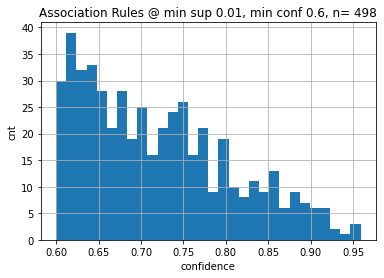

In [125]:
# 2.2.2.2.3 asso_rules_6 연관규칙에 대해 신뢰도의 분포를 히스토그램으로 확인 
#  (@최소지지도 0.01, 최소신뢰도 0.6)

asso_rules_6.***(*** , bins= 30)

plt.xlabel('confidence')
plt.ylabel('cnt')
txt='***'
plt.title(f'Association Rules {txt}')
plt.show()

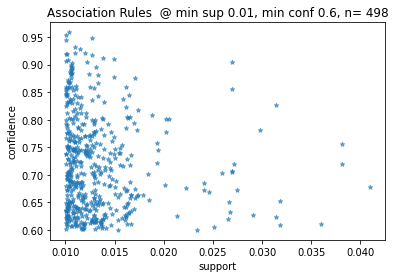

In [45]:
# 2.2.2.2.4 asso_rules_6 연관규칙에 대해 지지도와 신뢰도의 분포를 산포도로 확인 (@최소지지도 0.01, 최소신뢰도 0.6)
asso_rules_6.plot.***(***,***, alpha = 0.6, marker = '*')
plt.xlabel(***)
plt.ylabel(***)
plt.title(f'Association Rules  {***}')
plt.show()

## 2.2.3 연관규칙의 활용

### 2.2.3.1 sup>0.025, conf>0.75

In [46]:
# 2.2.3.1  asso_rules_6 연관규칙에서 지지도 0.025 이상, 신뢰도 0.75 이상의 건을 확인해보자.
filter = asso_rules_6.support.***(0.025) & asso_rules_6.confidence.***(0.75)
asso_rules_6[***]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
33,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038047,0.050415,0.031441,0.826371,16.391451,0.029523,5.469040
35,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.050415,0.052948,0.038146,0.756650,14.290468,0.035477,3.891732
73,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.038047,0.052948,0.029752,0.781984,14.768941,0.027738,4.343964
233,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.031441,0.052948,0.026921,0.856240,16.171372,0.025256,6.587736
235,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.029752,0.050415,0.026921,0.904841,17.947953,0.025421,9.978975


### 2.2.3.2 향상도 관찰

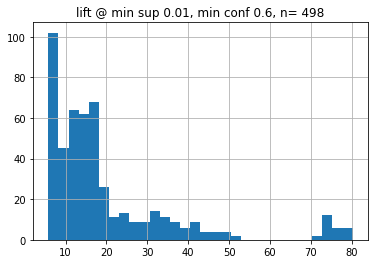

In [47]:
# 2.2.3.2 향상도 관찰
# 2.2.3.2.1 asso_rules_6 연관규칙의 향상도 분포 (@최소지지도 0.01, 최소신뢰도 0.6)
asso_rules_6.hist('***', bins = 30)
plt.title(f'*** {txt}')
plt.show()

In [48]:
# 2.2.3.2.2 asso_rules_6 연관규칙에서 향상도 70 이상의 건을 확인해보자.
filter = asso_rules_6.lift.***
asso_rules_6[***]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
38,(HERB MARKER MINT),(HERB MARKER BASIL),0.011921,0.012020,0.010331,0.866667,72.101653,0.010188,7.409850
39,(HERB MARKER BASIL),(HERB MARKER MINT),0.012020,0.011921,0.010331,0.859504,72.101653,0.010188,7.032800
40,(HERB MARKER PARSLEY),(HERB MARKER BASIL),0.011821,0.012020,0.010530,0.890756,74.105771,0.010388,9.043816
41,(HERB MARKER BASIL),(HERB MARKER PARSLEY),0.012020,0.011821,0.010530,0.876033,74.105771,0.010388,7.971307
42,(HERB MARKER ROSEMARY),(HERB MARKER BASIL),0.011921,0.012020,0.010629,0.891667,74.181508,0.010486,9.119815
43,(HERB MARKER BASIL),(HERB MARKER ROSEMARY),0.012020,0.011921,0.010629,0.884298,74.181508,0.010486,8.539828
44,(HERB MARKER BASIL),(HERB MARKER THYME),0.012020,0.011772,0.010431,0.867769,73.716393,0.010289,7.473476
45,(HERB MARKER THYME),(HERB MARKER BASIL),0.011772,0.012020,0.010431,0.886076,73.716393,0.010289,8.672268
46,(HERB MARKER MINT),(HERB MARKER PARSLEY),0.011921,0.011821,0.010530,0.883333,74.723319,0.010389,8.470102
47,(HERB MARKER PARSLEY),(HERB MARKER MINT),0.011821,0.011921,0.010530,0.890756,74.723319,0.010389,9.044726


### 2.2.3.3 레버리지 관찰

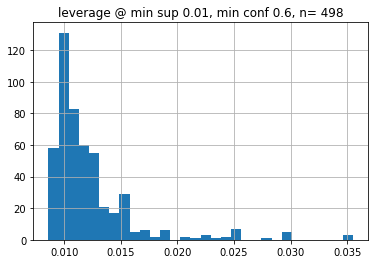

In [49]:
# 2.2.3.3 레버리지 관찰
# 2.2.3.3.1 asso_rules_6 연관규칙의 레버리지 분포 (@최소지지도 0.01, 최소신뢰도 0.6)
asso_rules_6.hist('***', bins = 30)
plt.title(f'*** {txt}')
plt.show()

In [50]:
# 2.2.3.3.2 asso_rules_6 연관규칙에서 레버리지 0.032 이상의 건을 확인해보자.
filter = asso_rules_6.leverage.*** 
asso_rules_6[filter]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
35,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.050415,0.052948,0.038146,0.75665,14.290468,0.035477,3.891732
36,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.052948,0.050415,0.038146,0.72045,14.290468,0.035477,3.396839
64,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.060498,0.103909,0.040977,0.67734,6.518587,0.034691,2.777198


### 2.2.3.4 확신 관찰

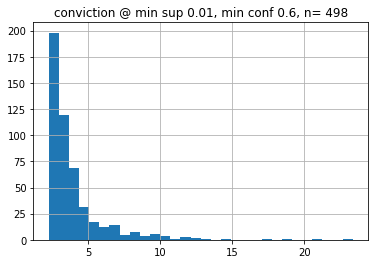

In [51]:
# 2.2.3.4 확신 관찰
# 2.2.3.4.1 asso_rules_6 연관규칙의 확신 분포 (@최소지지도 0.01, 최소신뢰도 0.6)
asso_rules_6.hist('***', bins = 30)
plt.title(f'*** {txt}')
plt.show()

In [52]:
# 2.2.3.4.2 asso_rules_6 연관규칙에서 확신 15 이상의 건을 확인해보자.
filter = asso_rules_6.conviction.***
asso_rules_6[filter]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
193,"(JAM MAKING SET PRINTED, SUKI SHOULDER BAG)",(DOTCOM POSTAGE),0.010828,0.035166,0.010381,0.958716,27.262459,0.010000,23.370420
241,"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",(HERB MARKER THYME),0.010679,0.011772,0.010083,0.944186,80.208007,0.009957,17.705757
243,"(HERB MARKER PARSLEY, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010580,0.011921,0.010083,0.953052,79.949120,0.009957,21.046089
405,"(REGENCY TEA PLATE ROSES, REGENCY TEA PLATE PINK)",(REGENCY TEA PLATE GREEN),0.013361,0.018924,0.012666,0.947955,50.092351,0.012413,18.850672


# 2.3 2차시 3강

## 2.3.1 국가별 분석 (프랑스)

### 2.3.1.1 프랑스 crosstab 생성

In [141]:
# 2.3.1.1 프랑스 거래 자료 추출
# 2.3.1.1.1  프랑스자료만 필터링
online_tmp_fr =  online_tmp[***]
online_tmp_fr

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France
30,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [142]:
# 2.3.1.1.2 프랑스 거래 확인 - 수치형
online_tmp_fr.***

,Quantity,UnitPrice,CustomerID
count,8408.000000,8408.000000,8342.000000
mean,13.333016,4.399713,12678.377128
std,21.069963,65.505260,277.279060
min,1.000000,0.000000,12413.000000
25%,6.000000,1.250000,12571.000000
50%,10.000000,1.790000,12678.000000
75%,12.000000,3.750000,12689.000000
max,912.000000,4161.060000,14277.000000


In [143]:
# 2.3.1.1.3 프랑스 거래 확인 - 비수치형
online_tmp_fr.describe(exclude=['float','int'] )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,8408.0,8408,8408,8408,8408
unique,392.0,1542,1563,393,1
top,570672.0,POST,POSTAGE,2011-10-11 14:52:00,France
freq,259.0,300,300,259,8408
first,NaN,NaN,NaN,2010-12-01 08:45:00,NaN
last,NaN,NaN,NaN,2011-12-09 12:50:00,NaN


* 잠깐, 392건 트랜젝션인데, Top 상품이 POSTAGE로 300개의 거래에 포함된다. 
* 무의미한 분석을 방지하기 위해서 POSTAGE 트랜제션을 제외하고 데이터를 재구성한다.  

In [144]:
# 2.3.1.1.4 online_tmp_fr에서 상품별로 groupby를 하여 건수의 분포를 먼저 살펴본다. 

online_tmp_fr.groupby(['Description']).***.***

Description
POSTAGE                               300
RABBIT NIGHT LIGHT                     74
RED TOADSTOOL LED NIGHT LIGHT          71
PLASTERS IN TIN WOODLAND ANIMALS       68
PLASTERS IN TIN CIRCUS PARADE          66
ROUND SNACK BOXES SET OF4 WOODLAND     62
LUNCH BAG RED RETROSPOT                60
LUNCH BOX WITH CUTLERY RETROSPOT       56
PLASTERS IN TIN SPACEBOY               54
RED RETROSPOT MINI CASES               54
dtype: int64

* 우표만 제거하면 될 것 같다.

In [146]:
# 2.3.1.1.5 우표 트랜젝션을 제외하여 online_tmp_fr을 재구성
online_tmp_fr = online_tmp_fr[***]

In [147]:
# 2.3.1.1.6 프랑스 거래 재확인 -수치형(우표제외)
online_tmp_fr.describe()

,Quantity,UnitPrice,CustomerID
count,8108.000000,8108.000000,8042.000000
mean,13.724593,3.839639,12679.898533
std,21.353250,66.583173,281.236979
min,1.000000,0.000000,12413.000000
25%,6.000000,1.000000,12571.000000
50%,10.000000,1.650000,12674.000000
75%,12.000000,2.950000,12689.000000
max,912.000000,4161.060000,14277.000000


In [148]:
# 2.3.1.1.7 프랑스 거래 재확인 - 비수치형 (우표제외)
online_tmp_fr.describe(exclude=['float','int'] )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,8108.0,8108.0,8108,8108,8108
unique,387.0,1541.0,1562,388,1
top,570672.0,23084.0,RABBIT NIGHT LIGHT,2011-10-11 14:52:00,France
freq,259.0,74.0,74,259,8108
first,NaN,NaN,NaN,2010-12-01 08:45:00,NaN
last,NaN,NaN,NaN,2011-12-09 12:50:00,NaN


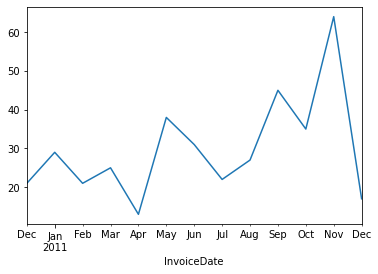

In [149]:
# 2.3.1.1.8 월별 거래건수 @fr
online_tmp_fr.groupby(['InvoiceDate','InvoiceNo'])['StockCode'].count()\
                .reset_index().set_index('InvoiceDate')\
                .resample('M')['InvoiceNo'].count().plot() ;

#### onlne_tr_fr 생성

In [150]:
# 2.3.1.1.9 연관분석을 위한 crosstab 생성 (387 x 1562)
online_tr_fr =  online_tmp_fr.pivot_table(values = 'Quantity',
                                         index= 'InvoiceNo', 
                                         columns = 'Description',
                                         aggfunc = isExist  ).fillna(False)
online_tr_fr.shape

(387, 1562)

* 프랑스에서는 387건의 트랜젝션, 1562종류의 상품을 다룬다.  (POSTAGE 제외)

### 2.3.1.2 프랑스 빈발항목 분석

In [151]:
# 2.3.1.2.1 가장 많이 팔린 상품을 10개를 확인해보자. 
online_tr_fr.***.***

Description
RABBIT NIGHT LIGHT                    74
RED TOADSTOOL LED NIGHT LIGHT         71
PLASTERS IN TIN WOODLAND ANIMALS      67
PLASTERS IN TIN CIRCUS PARADE         66
ROUND SNACK BOXES SET OF4 WOODLAND    62
LUNCH BAG RED RETROSPOT               60
LUNCH BOX WITH CUTLERY RETROSPOT      56
PLASTERS IN TIN SPACEBOY              54
RED RETROSPOT MINI CASES              54
SET/6 RED SPOTTY PAPER CUPS           54
dtype: int64

In [ ]:
# 2.3.1.2.2  판매건수의 분포 시각화
# 빨간색과 초록색의 수평 수직선은 눈으로 확인하며 적절값을 선정한다. 
# x의 항목개수가 100개가 되도록 데이터 슬라이싱
#  즉, 상품수에서 step 간격을 조정한 슬라이싱 (약 1500상품/15스텝)

online_tr_fr.sum().nlargest(***)[::**].plot()
plt.title('sales count by item @ fr')
plt.ylabel('sales count')
plt.xticks(rotation=45)
#plt.ylim(0,300)
plt.ylim(0,100)
plt.xlim(0,100)

#plt.axvline(x=**, color='g', linewidth=1)
#plt.axhline(y=**, color='r', linewidth=1)
plt.show()

* 총 387 트랜젝션 중 20건 이상 판매된 (약 0.05의 지지도) 상품은 1562종의 상품 중 5% 에 해당, 약 75개 정도 되며, 이를 분석 대상으로 하겠다. 

#### freq_its_fr ms=0.05

In [153]:
# 2.3.1.2.3 최소지지도 0.05로 빈발항목을 도출해보자. @fr
freq_its_fr = apriori (***, 
                       min_support=***, 
                       use_colnames=True,
                       low_memory=True)
freq_its_fr

,support,itemsets
0,0.072351,(4 TRADITIONAL SPINNING TOPS)
1,0.098191,(ALARM CLOCK BAKELIKE GREEN)
2,0.103359,(ALARM CLOCK BAKELIKE PINK)
3,0.095607,(ALARM CLOCK BAKELIKE RED)
4,0.069767,(ASSORTED COLOUR MINI CASES)
...,...,...
108,0.103359,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET..."
109,0.124031,"(SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT..."
110,0.064599,"(ALARM CLOCK BAKELIKE RED, ALARM CLOCK BAKELIK..."
111,0.069767,"(PLASTERS IN TIN SPACEBOY, PLASTERS IN TIN WOO..."


* 단일항목 포함 113건 생성

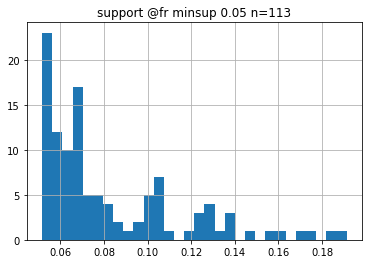

In [156]:
# 2.3.1.2.4 최소지지도 0.05로 빈발항목 분포. @fr (단일항목 포함)
freq_its_fr.***.***(bins=30) 
plt.title('support @fr minsup 0.05 n=113')
plt.show()

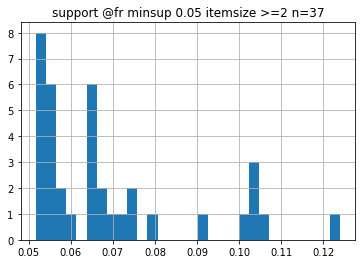

In [157]:
# 2.3.1.2.5  빈발 항목 건수 2건 이상인 경우의 분포

## 항목집합에 2개 이상 항목 건 마킹 'length 컬럼' 
freq_its_fr['length'] = freq_its_fr.***.***

# 히스토그램 생성
freq_its_fr[***].support.hist(bins=30)
plt.title(f'support @fr minsup 0.05 itemsize >=2 n={freq_its_fr.length.ge(2).sum()}') 
plt.show();

* 2개 이상의 항목이 함께 지지도가 0.05 이상이 되는 케이스가 37건 있었다. 

In [177]:
# 2.3.1.2.6 2건 이상이면서 지지도가 0.10 이상인 빈발항목의 목록을 출력

filter = freq_its_fr.*** & freq_its_fr.***
freq_its_fr[filter]

,support,itemsets,length
98,0.103359,"(PLASTERS IN TIN WOODLAND ANIMALS, PLASTERS IN...",2
102,0.105943,"(PLASTERS IN TIN SPACEBOY, PLASTERS IN TIN WOO...",2
107,0.103359,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",2
108,0.103359,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",2
109,0.124031,"(SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT...",2
112,0.100775,"(SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT...",3


### 2.3.1.3 프랑스 연관규칙 분석

#### asso_rules_5_fr (ms=0.05, mc=0.5)

In [158]:
# 2.3.1.3.1  최소신뢰도 0.5로 연관규칙을 도출
asso_rules_5_fr = association_rules(***, 
                               ***, 
                               ***)
asso_rules_5_fr

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.098191,0.103359,0.074935,0.763158,7.383553,0.064786,3.785817
1,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.103359,0.098191,0.074935,0.725000,7.383553,0.064786,3.279305
2,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095607,0.098191,0.080103,0.837838,8.532717,0.070716,5.561154
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.098191,0.095607,0.080103,0.815789,8.532717,0.070716,4.909561
4,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.095607,0.103359,0.074935,0.783784,7.583108,0.065054,4.146964
5,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.103359,0.095607,0.074935,0.725000,7.583108,0.065054,3.288701
6,(ALARM CLOCK BAKELIKE RED),(ROUND SNACK BOXES SET OF4 WOODLAND),0.095607,0.160207,0.051680,0.540541,3.374019,0.036363,1.827785
7,(CHILDRENS CUTLERY SPACEBOY),(CHILDRENS CUTLERY DOLLY GIRL),0.069767,0.072351,0.064599,0.925926,12.797619,0.059552,12.523256
8,(CHILDRENS CUTLERY DOLLY GIRL),(CHILDRENS CUTLERY SPACEBOY),0.072351,0.069767,0.064599,0.892857,12.797619,0.059552,8.682171
9,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.100775,0.126615,0.072351,0.717949,5.670330,0.059592,3.096547


* 50건의 규칙이 도출 됨

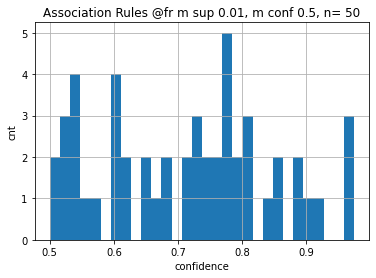

In [159]:
# 2.3.1.3.2 asso_rules_5_fr 연관규칙에 대해  신뢰도의 분포를 히스토그램으로 확인 
#         (@최소지지도 0.01, 최소신뢰도 0.5 fr)

asso_rules_5_fr.hist('***', bins= 30)
plt.xlabel('***')
plt.ylabel('cnt')
txt = '@fr m sup 0.01, m conf 0.5, n= ***'
plt.title(f'Association Rules {txt}')
plt.show()

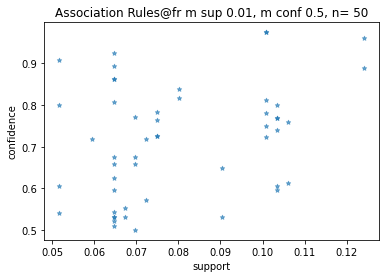

In [160]:
# 2.3.1.3.3  asso_rules_5_fr 연관규칙에 대해 지지도와 신뢰도의 분포를 산포도로 확인 
# (@최소지지도 0.01, 최소신뢰도 0.5 fr)
asso_rules_5_fr.plot.***('***','***', alpha = 0.6, marker = '*')
plt.xlabel('***')
plt.ylabel('***')
plt.title(f'Association Rules{txt}')
plt.show()

In [167]:
# 2.3.1.3.4 asso_rules_5_fr 연관규칙에서 지지도 0.10 이상, 신뢰도 0.7 이상의 건을 확인해보자.
filter = asso_rules_5_fr.support.*** & asso_rules_5_fr.confidence.***
print(asso_rules_5_fr[filter].shape, 'mins = 0.10, minc = 0.7')
asso_rules_5_fr[filter]


(13, 9) mins = 0.10, minc = 0.7


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
26,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.139535,0.173127,0.105943,0.759259,4.385572,0.081786,3.434705
29,(SET/6 RED SPOTTY PAPER CUPS),(SET/20 RED RETROSPOT PAPER NAPKINS),0.139535,0.134367,0.103359,0.740741,5.512821,0.084610,3.338870
30,(SET/20 RED RETROSPOT PAPER NAPKINS),(SET/6 RED SPOTTY PAPER CUPS),0.134367,0.139535,0.103359,0.769231,5.512821,0.084610,3.728682
31,(SET/6 RED SPOTTY PAPER PLATES),(SET/20 RED RETROSPOT PAPER NAPKINS),0.129199,0.134367,0.103359,0.800000,5.953846,0.085999,4.328165
32,(SET/20 RED RETROSPOT PAPER NAPKINS),(SET/6 RED SPOTTY PAPER PLATES),0.134367,0.129199,0.103359,0.769231,5.953846,0.085999,3.773471
33,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.129199,0.139535,0.124031,0.960000,6.880000,0.106003,21.511628
34,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.139535,0.129199,0.124031,0.888889,6.880000,0.106003,7.837209
45,"(SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT...",(SET/20 RED RETROSPOT PAPER NAPKINS),0.124031,0.134367,0.100775,0.812500,6.046875,0.084110,4.616710
46,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",(SET/6 RED SPOTTY PAPER CUPS),0.103359,0.139535,0.100775,0.975000,6.987500,0.086353,34.418605
47,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.103359,0.129199,0.100775,0.975000,7.546500,0.087421,34.832041


### 2.3.1.4 프랑스 lift/lev/conv

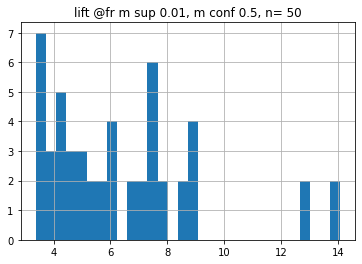

In [168]:
# 2.3.1.4.1  asso_rules_5_fr 연관규칙의 향상도 분포 (@최소지지도 0.01, 최소신뢰도 0.5)
asso_rules_5_fr.***(***, bins = 30)
plt.title(f'lift {txt}')
plt.show()

In [169]:
# 2.3.1.4.2 asso_rules_5_fr 연관규칙에서 향상도 12 이상의 건을 확인해보자.
filter = asso_rules_5_fr.***
asso_rules_5_fr[filter]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7,(CHILDRENS CUTLERY SPACEBOY),(CHILDRENS CUTLERY DOLLY GIRL),0.069767,0.072351,0.064599,0.925926,12.797619,0.059552,12.523256
8,(CHILDRENS CUTLERY DOLLY GIRL),(CHILDRENS CUTLERY SPACEBOY),0.072351,0.069767,0.064599,0.892857,12.797619,0.059552,8.682171
19,(PACK OF 6 SKULL PAPER CUPS),(PACK OF 6 SKULL PAPER PLATES),0.064599,0.056848,0.051680,0.800000,14.072727,0.048007,4.715762
20,(PACK OF 6 SKULL PAPER PLATES),(PACK OF 6 SKULL PAPER CUPS),0.056848,0.064599,0.051680,0.909091,14.072727,0.048007,10.289406


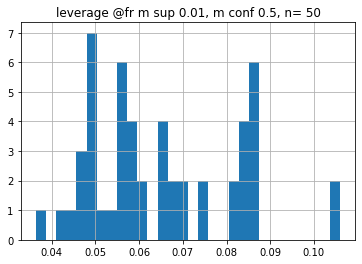

In [170]:
# 2.3.1.4.3 asso_rules_5_fr 연관규칙의 레버리지 분포 (@최소지지도 0.01, 최소신뢰도 0.5)
asso_rules_5_fr.***('***', bins = 30)
plt.title(f'*** {txt}')
plt.show()

In [173]:
# 2.3.1.4.4 asso_rules_5_fr 연관규칙에서 레버리지 0.085 이상의 건을 확인해보자.
filter = asso_rules_5_fr.***
asso_rules_5_fr[filter]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
31,(SET/6 RED SPOTTY PAPER PLATES),(SET/20 RED RETROSPOT PAPER NAPKINS),0.129199,0.134367,0.103359,0.800000,5.953846,0.085999,4.328165
32,(SET/20 RED RETROSPOT PAPER NAPKINS),(SET/6 RED SPOTTY PAPER PLATES),0.134367,0.129199,0.103359,0.769231,5.953846,0.085999,3.773471
33,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.129199,0.139535,0.124031,0.960000,6.880000,0.106003,21.511628
34,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.139535,0.129199,0.124031,0.888889,6.880000,0.106003,7.837209
46,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",(SET/6 RED SPOTTY PAPER CUPS),0.103359,0.139535,0.100775,0.975000,6.987500,0.086353,34.418605
47,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.103359,0.129199,0.100775,0.975000,7.546500,0.087421,34.832041
48,(SET/6 RED SPOTTY PAPER PLATES),"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",0.129199,0.103359,0.100775,0.780000,7.546500,0.087421,4.075640
49,(SET/6 RED SPOTTY PAPER CUPS),"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",0.139535,0.103359,0.100775,0.722222,6.987500,0.086353,3.227907


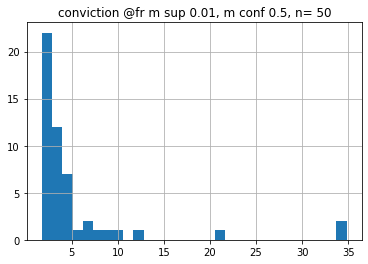

In [174]:
# 2.3.1.4.5 asso_rules_5_fr 연관규칙의 확신 분포 (@최소지지도 0.01, 최소신뢰도 0.5)
asso_rules_5_fr.replace(np.inf, np.nan).***('***', bins = 30 )
plt.title(f'*** {txt}')
plt.show()

In [176]:
# 2.3.1.4.6 asso_rules_5_fr 연관규칙에서 확신 12 이상의 건을 확인해보자.
filter = ***.conviction.ge(12) 
asso_rules_5_fr[filter]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7,(CHILDRENS CUTLERY SPACEBOY),(CHILDRENS CUTLERY DOLLY GIRL),0.069767,0.072351,0.064599,0.925926,12.797619,0.059552,12.523256
33,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.129199,0.139535,0.124031,0.960000,6.880000,0.106003,21.511628
46,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",(SET/6 RED SPOTTY PAPER CUPS),0.103359,0.139535,0.100775,0.975000,6.987500,0.086353,34.418605
47,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.103359,0.129199,0.100775,0.975000,7.546500,0.087421,34.832041


## 2.3.2 국가별 분석 (독일) 

### 2.3.2.1 독일 crosstab 생성

In [ ]:
# 2.3.2.1 독일 거래 자료 추출
# 독일 건도 우표 제외하고 추출
# 2.3.2.1.1 Country == 'Germany',Description != 'POSTAGE' 로 필터링
online_tmp_gm = online_tmp[online_tmp.Country=='Germany']
online_tmp_gm = online_tmp_gm[online_tmp_gm.Description !='POSTAGE']
online_tmp_gm

In [ ]:
# 2.3.3.1.2  독일 거래 확인 - 수치형 
online_tmp_gm.describe()

In [ ]:
# 2.3.3.1.3 독일 거래 확인 -비수치형
online_tmp_gm.describe(exclude=['float','int'] )


#### online_tr_gm ms=0.03

In [ ]:
# 2.3.3.1.4 연관분석을 위한 crosstab 생성 (449 x 1694)
online_tr_gm =  online_tmp_gm.pivot_table(values = 'Quantity',
                                         index= 'InvoiceNo', 
                                         columns = 'Description',
                                         aggfunc = isExist  ).fillna(False)
online_tr_gm.shape

* 독일에서는 449건의 트랜젝션, 1694종류의 상품을 다룬다. 

### 2.3.2.2 독일 빈발항목 분석

In [ ]:
# 2.3.2.2.1 독일에서 가장 많이 팔린 상품 10개를 확인해보자. 
online_tr_gm.sum().nlargest(10)

In [ ]:
# 2.3.2.2.2 판매건수의 분포 시각화
# 빨간색과 초록색의 수평 수직선은 눈으로 확인하며 적절값을 선정한다. 
# x의 항목개수가 100개가 되도록 데이터 슬라이싱
#  즉, 상품수에서 step 간격을 조정한 슬라이싱 (약 1500상품/15스텝)

online_tr_gm.sum().nlargest(1500)[::15].plot()

plt.title('sales count by item @ gm')
plt.ylabel('sales count')
plt.xticks(rotation=45)
plt.ylim(0,112)
plt.xlim(0,100)

#plt.axhline(y=14, color='r', linewidth=1)
#plt.axvline(x=10, color='g', linewidth=1)
plt.show()

* 상위 10% 정도의 상품에 대해서 분석해보고자 한다. 교차되는 y값이 14, 14/440 = 0.03 정도 되므로 최소 지지도를 0.03으로 한다. 


#### freq_its_gm

In [ ]:
# 2.3.2.2.3 최소지지도 0.03로 빈발항목을 도출해보자. @gm
freq_its_gm = apriori (online_tr_gm, min_support=0.03, use_colnames=True,
                            low_memory=True)
freq_its_gm

In [ ]:
# 2.3.2.2.4 최소지지도 0.03로 빈발항목 분포. @gm
freq_its_gm.support.hist(bins=30) 
plt.title('support @gm minsup 0.03 n=487')
plt.show()

In [ ]:
# 2.3.2.2.5 빈발 항목 건수 2건 이상인 경우의 분포
freq_its_gm['length'] = freq_its_gm.itemsets.apply(lambda x: len(x))
freq_its_gm[freq_its_gm.length >=2].support.hist(bins=30)
plt.title(f'support @gm minsup 0.03 itemsize >=2 n={freq_its_gm.length.ge(2).sum()}') 
plt.show();

### 2.3.2.3 독일 연관규칙 분석

#### asso_rules_5_gm (ms=0.03, mc=0.5)

In [ ]:
# 2.3.2.3.1 최소신뢰도 0.5로 연관규칙을 도출
asso_rules_5_gm = association_rules(freq_its_gm, 
                               metric= 'confidence', 
                               min_threshold= 0.5)
asso_rules_5_gm

In [ ]:
# 2.3.2.3.2 asso_rules_5_gm 연관규칙에 대해  신뢰도의 분포를 히스토그램으로 확인 (@최소지지도 0.03, 최소신뢰도 0.5 gm)
asso_rules_5_gm.hist('confidence', bins= 30)
plt.xlabel('confidence')
plt.ylabel('cnt')
txt = '@gm m sup 0.03, m conf 0.5, n= 71'
plt.title(f'Association Rules {txt}')
plt.show()

In [ ]:
# 2.3.2.3.3 asso_rules_5_gm 연관규칙에 대해 지지도와 신뢰도의 분포를 산포도로 확인 (@최소지지도 0.03, 최소신뢰도 0.5 gm)
asso_rules_5_gm.plot.scatter('support','confidence', alpha = 0.6, marker = '*')
plt.xlabel('support')
plt.ylabel('confidence')
plt.title(f'Association Rules{txt}')
plt.show()

In [ ]:
# 2.3.2.3.4 asso_rules_5_gm 연관규칙에서 지지도 0.06 이상의 건을 확인해보자.
filter = asso_rules_5_gm.support.ge(0.06) 
asso_rules_5_gm[filter]


### 2.3.2.4 독일 lift/lev/conv

In [ ]:
# 2.3.2.4.1 asso_rules_5_gm 연관규칙의 향상도 분포 
asso_rules_5_gm.hist('lift', bins = 30)
plt.title(f'lift {txt}')
plt.show()

In [ ]:
# 2.3.2.4.2 asso_rules_5_gm 연관규칙에서 향상도 14 이상의 건을 확인해보자.
filter = asso_rules_5_gm.lift.ge(14) 
asso_rules_5_gm[filter]


In [ ]:
# 2.3.2.4.3 asso_rules_5_gm 연관규칙의 레버리지 분포
asso_rules_5_gm.hist('leverage', bins = 30)
plt.title(f'leverage {txt}')
plt.show()

In [ ]:
# 2.3.2.4.4 asso_rules_5_gm 연관규칙에서 레버리지 0.045 이상의 건을 확인해보자.
filter = asso_rules_5_gm.leverage.ge(0.045) 
asso_rules_5_gm[filter]

In [ ]:
# 2.3.2.4.5 asso_rules_5_gm 연관규칙의 확신 분포 
asso_rules_5_gm.replace(np.inf, np.nan).hist('conviction', bins = 30 )
plt.title(f'conviction {txt}')
plt.show()

In [ ]:
# 2.3.2.4.6 asso_rules_5_gm 연관규칙에서 확신 10 이상의 건을 확인해보자.
filter = asso_rules_5_gm.conviction.ge(10) 
asso_rules_5_gm[filter]

## 2.3.3 카테고리별 분석

* 상품을 유형화 하여 묶음 단위로 분석 할 수 없을까?  상품 코드를 살펴본다. 

In [ ]:
# 2.3.3.1 StockCode와 Description을 관찰해보자. 
online_tmp[***]

In [ ]:
# 2.3.3.2 중복을 제거하고, StockCode 순으로 정렬한다. 
online_tmp[***].drop_duplicates().astype(str).sort_values('StockCode')

* 항목을 유형화 하는 방법에는 어떤 전략이 있을 수 있을까? 